In [ ]:
!pip install catboost
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [ ]:

# Load the Covertype dataset
print("Loading Covertype dataset...")
X, y = fetch_covtype(return_X_y=True)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Unique values in y:", np.unique(y))

print("-" * 40)





Loading Covertype dataset...
Shape of X: (581012, 54)
Shape of y: (581012,)
Unique values in y: [1 2 3 4 5 6 7]
----------------------------------------


In [ ]:

from collections import Counter

unique_values, counts = np.unique(y, return_counts=True)

print("Number of unique values in y:", len(unique_values))
print("Number of each unique value:")
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")


Number of unique values in y: 7
Number of each unique value:
Value: 1, Count: 211840
Value: 2, Count: 283301
Value: 3, Count: 35754
Value: 4, Count: 2747
Value: 5, Count: 9493
Value: 6, Count: 17367
Value: 7, Count: 20510


In [ ]:


# Create a dictionary to store the desired counts
desired_counts = {1: 20000, 2: 20000, 3: 20000, 4: 2747, 5: 9493, 6: 17367, 7: 20510}

# Create lists to store the new X and y values
new_X = []
new_y = []

# Iterate through the unique values and their counts
for value, count in zip(unique_values, counts):
    # If the value is in the desired counts, add the corresponding samples to the new lists
    if value in desired_counts:
        indices = np.where(y == value)[0]
        # Use a random sample to get the desired number of instances for each value.
        sampled_indices = np.random.choice(indices, size=min(desired_counts[value], count), replace=False)
        new_X.extend(X[sampled_indices])
        new_y.extend(y[sampled_indices])


# Convert the new lists to numpy arrays
X = np.array(new_X)
y = np.array(new_y)

# Print the new shape of X and y
print("-" * 40)
print("New Shape of X:", X.shape)
print("New Shape of y:", y.shape)

unique_values, counts = np.unique(y, return_counts=True)
print("Number of unique values in y:", len(unique_values))
print("Number of each unique value:")
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

----------------------------------------
New Shape of X: (110117, 54)
New Shape of y: (110117,)
Number of unique values in y: 7
Number of each unique value:
Value: 1, Count: 20000
Value: 2, Count: 20000
Value: 3, Count: 20000
Value: 4, Count: 2747
Value: 5, Count: 9493
Value: 6, Count: 17367
Value: 7, Count: 20510


In [ ]:
# Split dataset into training and testing sets
print("Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Splitting dataset...


In [ ]:

# Split training data into patches
def split_into_patches(X, y, patch_size):
    """Split the dataset into smaller patches."""
    num_patches = int(np.ceil(X.shape[0] / patch_size))
    for i in range(num_patches):
        start = i * patch_size
        end = min((i + 1) * patch_size, X.shape[0])
        yield X[start:end], y[start:end]

# Patch size (number of samples per patch)
patch_size = 20000  # Adjust this based on your system's memory and speed

# Dictionary of classification algorithms
algorithms = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),  # Suppress LightGBM logs
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000)
}


Training Logistic Regression...
Logistic Regression Metrics:
Accuracy: 0.6035
Precision: 0.5985
Recall: 0.6035
F1 Score: 0.5950
----------------------------------------
Training Decision Tree...
Decision Tree Metrics:
Accuracy: 0.8842
Precision: 0.8838
Recall: 0.8842
F1 Score: 0.8840
----------------------------------------
Training Random Forest...
Random Forest Metrics:
Accuracy: 0.9254
Precision: 0.9248
Recall: 0.9254
F1 Score: 0.9249
----------------------------------------
Training SVC...
SVC Metrics:
Accuracy: 0.6402
Precision: 0.6283
Recall: 0.6402
F1 Score: 0.6292
----------------------------------------
Training KNN...
KNN Metrics:
Accuracy: 0.9101
Precision: 0.9091
Recall: 0.9101
F1 Score: 0.9084
----------------------------------------
Training Naive Bayes...
Training using patches.. Naive Bayes
Naive Bayes Metrics:
Accuracy: 0.5531
Precision: 0.6482
Recall: 0.5531
F1 Score: 0.5015
----------------------------------------
Training AdaBoost...
AdaBoost Metrics:
Accuracy: 0.52

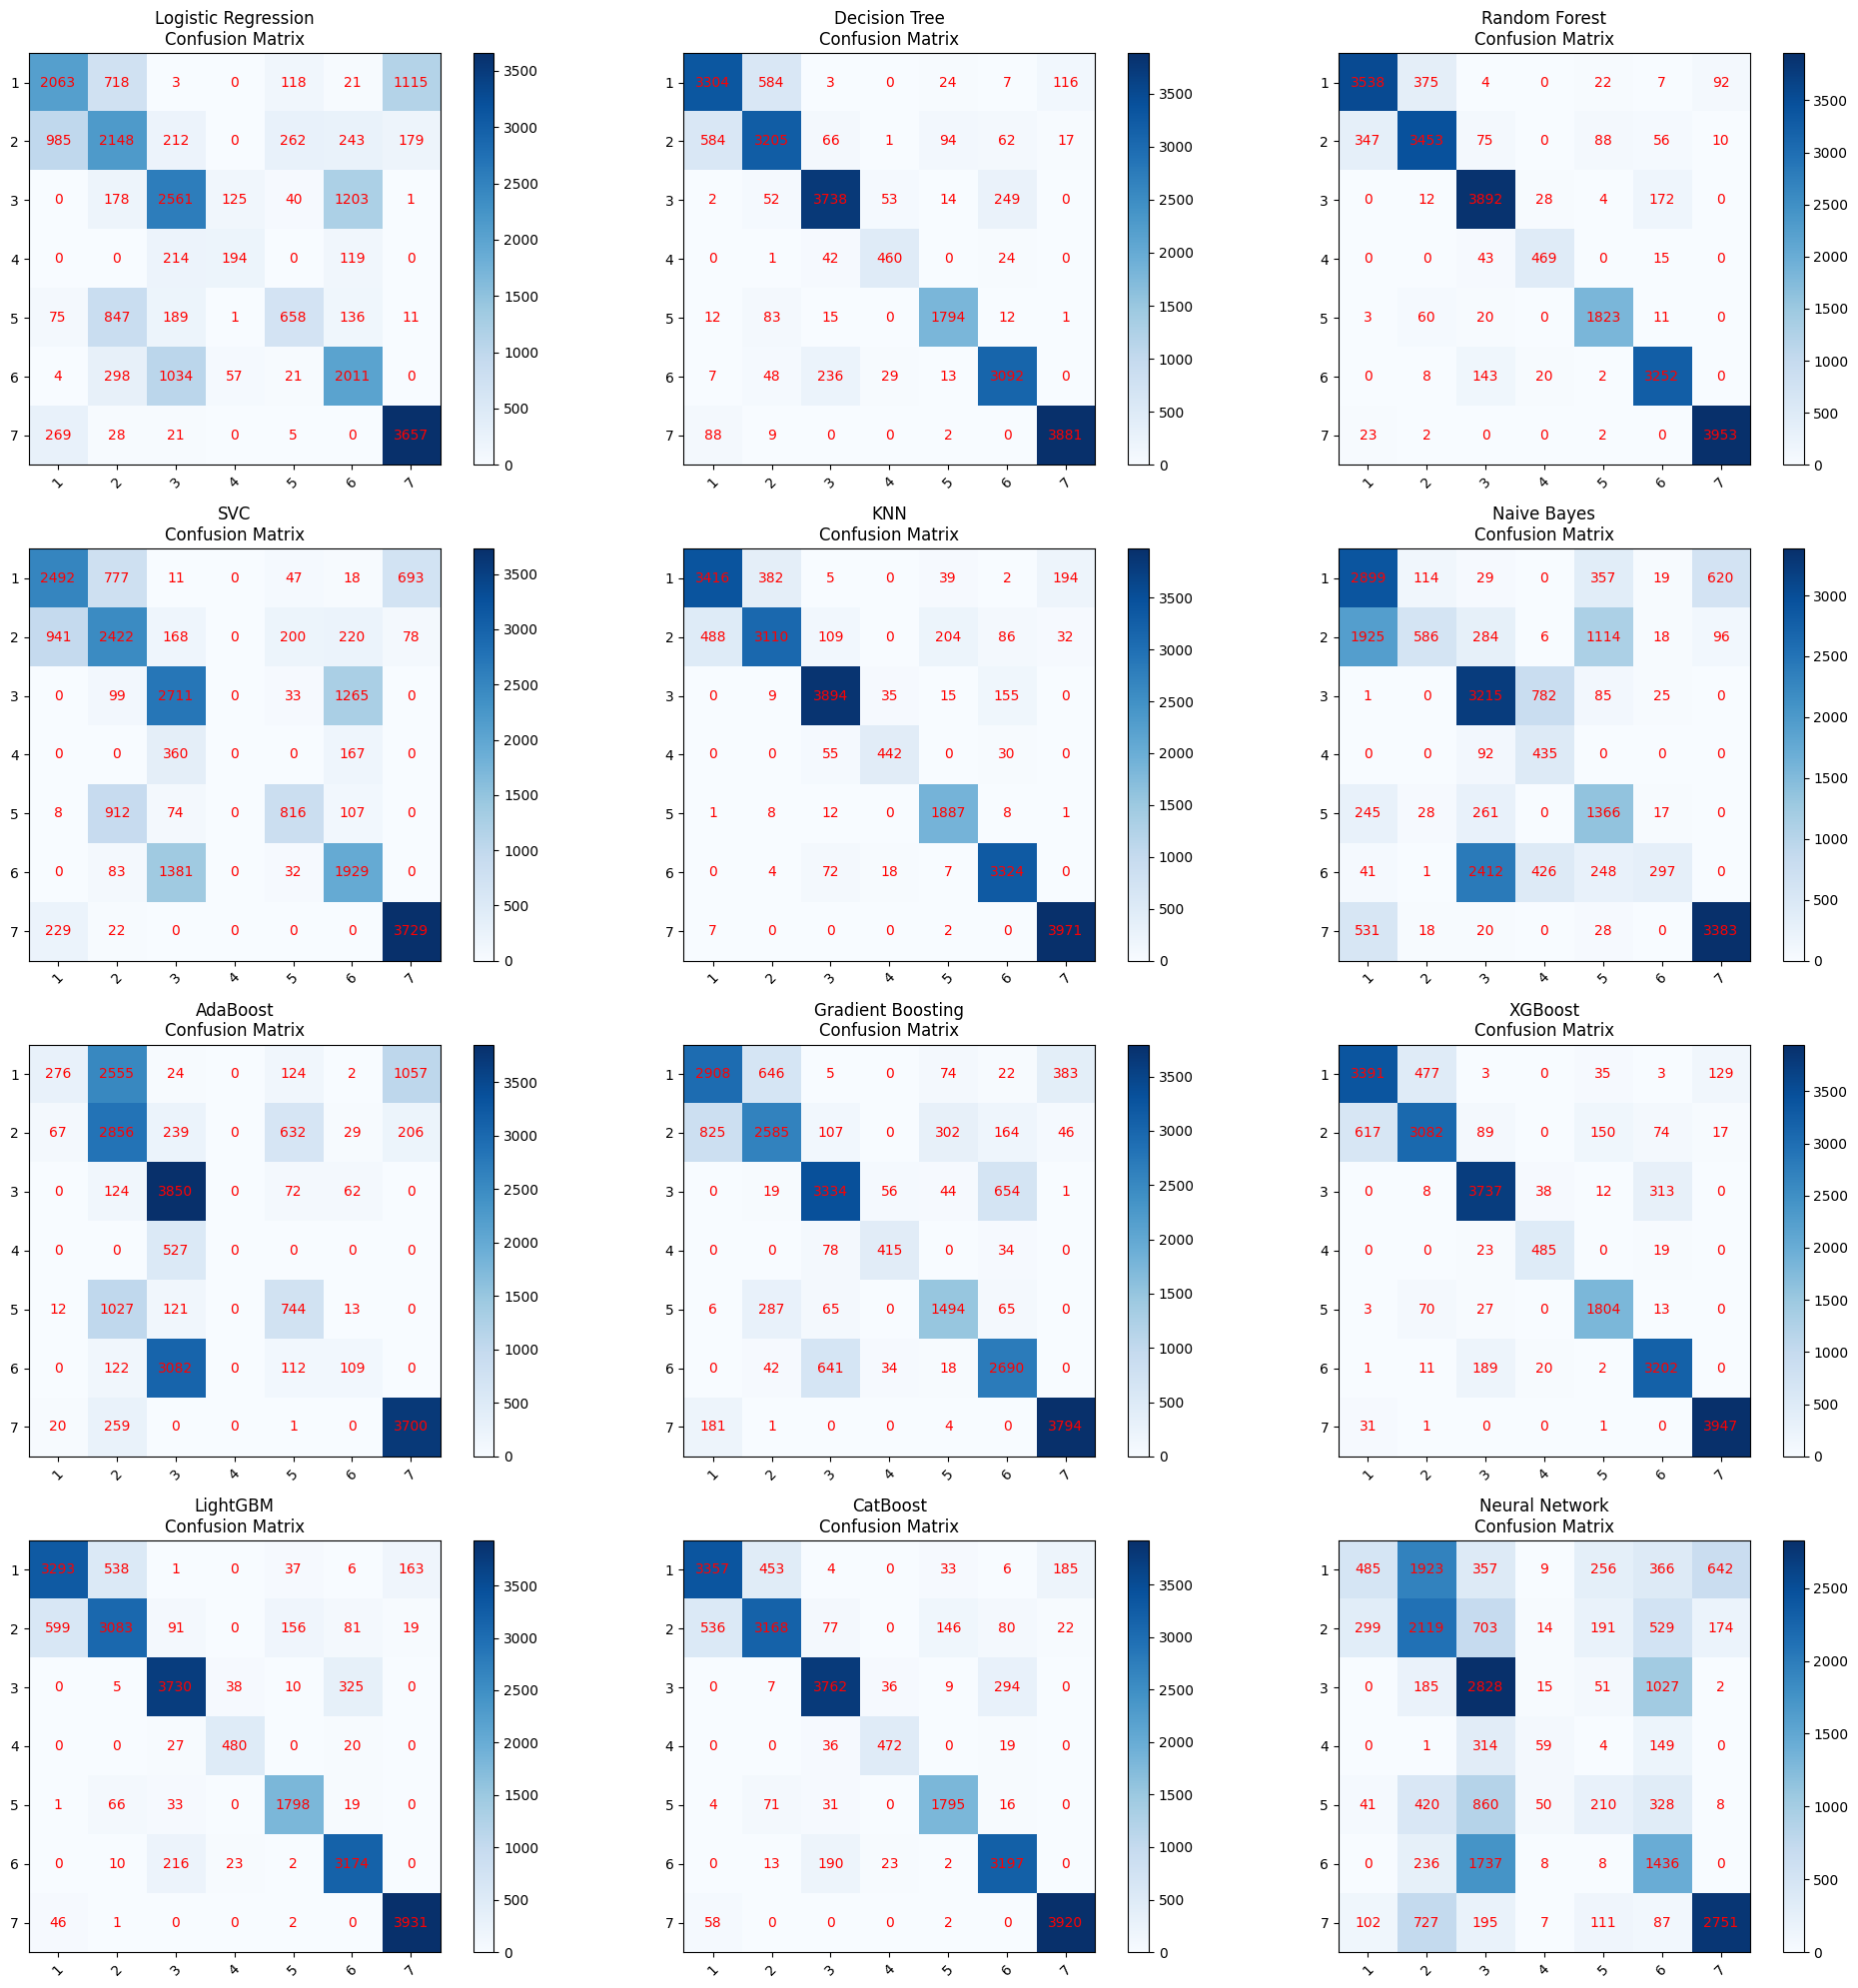

In [ ]:
# Initialize a figure for confusion matrices
plt.figure(figsize=(20, 20))

# Train and evaluate each algorithm
for i, (name, model) in enumerate(algorithms.items()):
    print(f"Training {name}...")

    # Check if the model is XGBoost, LightGBM, or CatBoost
    if name in ["XGBoost", "LightGBM", "CatBoost"]:
        y_train_adjusted = y_train - 1
        y_test_adjusted = y_test - 1
    else:
        y_train_adjusted = y_train
        y_test_adjusted = y_test

    # Check if the model supports incremental learning
    if hasattr(model, 'partial_fit'):
        # Train incrementally using patches
        print(f"Training using patches.. {name}")
        for X_patch, y_patch in split_into_patches(X_train, y_train_adjusted, patch_size):
            model.partial_fit(X_patch, y_patch, classes=np.unique(y_train_adjusted))
    else:
        # Train on the entire dataset
        model.fit(X_train, y_train_adjusted)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test_adjusted, y_pred)
    precision = precision_score(y_test_adjusted, y_pred, average='weighted')
    recall = recall_score(y_test_adjusted, y_pred, average='weighted')
    f1 = f1_score(y_test_adjusted, y_pred, average='weighted')

    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 40)

    # Plot confusion matrix in a subplot
    cm = confusion_matrix(y_test_adjusted, y_pred)
    plt.subplot(4, 3, i+1)  # 4 rows, 3 columns for 12 algorithms
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{name}\nConfusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(7)  # 7 classes (forest cover types)
    plt.xticks(tick_marks, range(1, 8), rotation=45)
    plt.yticks(tick_marks, range(1, 8))

    # Labeling the matrix
    for j in range(7):
        for k in range(7):
            plt.text(k, j, format(cm[j, k], 'd'), ha="center", va="center", color="red")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:


# Create the directory if it doesn't exist
directory = "models"
if not os.path.exists(directory):
    os.makedirs(directory)

# ... (Your existing code for training models) ...

# Save each trained model to the 'models' directory
for name, model in algorithms.items():
    filename = os.path.join(directory, f"{name}.joblib")
    joblib.dump(model, filename)
    print(f"Saved {name} model to {filename}")

Saved Logistic Regression model to models/Logistic Regression.joblib
Saved Decision Tree model to models/Decision Tree.joblib
Saved Random Forest model to models/Random Forest.joblib
Saved SVC model to models/SVC.joblib
Saved KNN model to models/KNN.joblib
Saved Naive Bayes model to models/Naive Bayes.joblib
Saved AdaBoost model to models/AdaBoost.joblib
Saved Gradient Boosting model to models/Gradient Boosting.joblib
Saved XGBoost model to models/XGBoost.joblib
Saved LightGBM model to models/LightGBM.joblib
Saved CatBoost model to models/CatBoost.joblib
Saved Neural Network model to models/Neural Network.joblib
